In [1]:
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting     

from sklearn.model_selection import GroupShuffleSplit

from sklearn.ensemble import GradientBoostingRegressor # G Boosting 


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Cross validations 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance

# Scores

from sklearn.metrics import mean_absolute_error as mae # Metric 
from sklearn.metrics import r2_score  as r2                 # Metric
from sklearn.metrics import mean_squared_error as mse  

# Optimisation 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Keras Model 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


# Other Visual etc 
import seaborn as sns
from matplotlib.patches import Patch  # Thi is a function to generate plot 
from matplotlib import cm
np.random.seed(1338)

# Optimization

from pyswarm import pso  

Using TensorFlow backend.


# Import Data

In [2]:
df1= pd.read_csv("Data.csv", index_col='Datetime', parse_dates=True) 
df2= pd.read_csv("Data2020.csv", index_col='Datetime', parse_dates=True)
df = pd.concat([df1,df2 ])

In [3]:
features=df
features.insert(1,"SMeanT",df.MeanT-df.SetTemp)  # Insert Output
features.SMeanT=features.SMeanT.shift(-1)       # Shift output by 1 place !

In [4]:
# Put Windows to end
windows=['Win_AFT', 'Win_AFB','Win_ARoof', 'Win_Akip', 'Win_BFT', 'Win_BFB', 'Win_Broof', 'Win_BKip','Vfloor_A','Vfloor_B']
features = features[ [ col for col in features.columns if col not in windows ] + windows ]
Names=list(features.columns)
unwanted = { 'group', 'WindD','SMeanT', 'WindDc','hourC','hourS','Rain','SetTemp','MeanC','Spa','WindDC_nan','WindDs'}
Xnames = [e for e in Names if e not in unwanted]
features['group'] = (features.index -features.index[0]).days

In [5]:
# Filter SMEANT 
features=features.loc[features.SMeanT.between(-3,4),:]

In [6]:
features=features.dropna(axis=0)

# Prapare Data 

In [7]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 40).split(features, groups=features['group']))

Train = features.iloc[train_inds]
Test = features.iloc[test_inds]

X = Train[Xnames].values
y = Train["SMeanT"].values  
print("X.shape:  ", X.shape)
print("y.shape:  ", y.shape)

X_test = Test[Xnames].values
y_test = Test["SMeanT"].values  
print("X.shape:  ", X_test.shape)
print("y.shape:  ", y_test.shape)

X.shape:   (9830, 19)
y.shape:   (9830,)
X.shape:   (3987, 19)
y.shape:   (3987,)


In [8]:
group=Train.group
n_splits=5
cv=GroupShuffleSplit(n_splits,random_state=24) 
ng=len(np.unique(features["group"].values))

# Baseline

# G Boosting Tune Hyperparameters

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   22.9s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  9.2min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 13.0min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 15.6min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 16.8min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 19.2min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 26.2min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 28.5min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 35.9min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed: 41.6min
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed: 49.5min finished
C:\Users\au327049\Conda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is de

Scores for each itteration is:  [-0.17434565 -0.52367257 -0.15878941 -0.23803674 -0.1479491  -0.71949965
 -0.17872848 -0.17474608 -0.17182473 -0.16271292 -0.23740655 -0.15143378
 -0.70849955 -0.16371632 -0.71014125 -0.33003117 -0.16364556 -0.17718022
 -0.15477005 -0.17459356 -0.16270657 -0.71656514 -0.39742813 -0.17722274
 -0.23783356]
 
Best parameter found is:  {'gradientboostingregressor__n_estimators': 1000, 'gradientboostingregressor__min_samples_split': 3, 'gradientboostingregressor__min_samples_leaf': 4, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.25}
Best score is : -0.14794909792615138


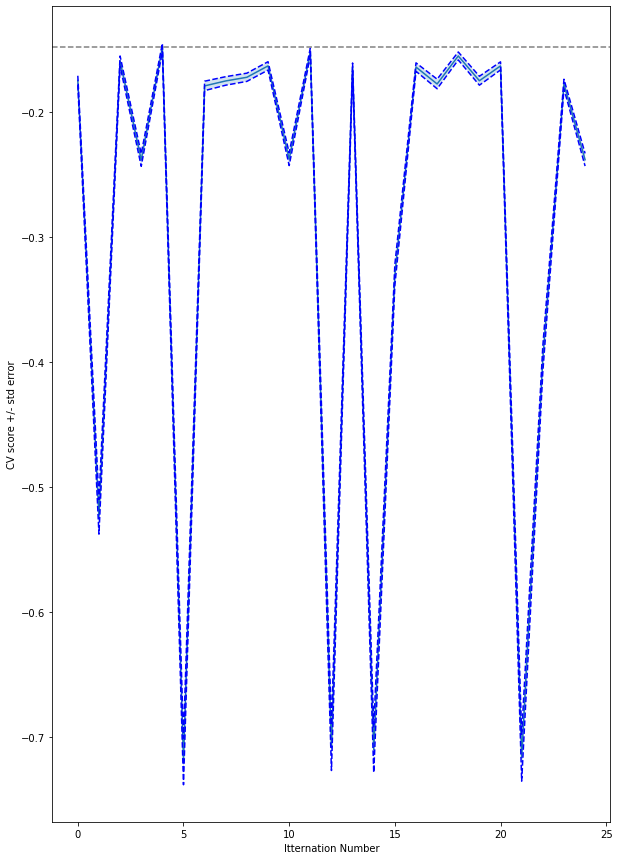

In [9]:
# Define grid for Optimization 
learning_rate = [0.25, 0.1,0.01,0.001]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree



GBC = make_pipeline( StandardScaler(), GradientBoostingRegressor( ) )

random_grid = {'gradientboostingregressor__learning_rate': learning_rate,
               'gradientboostingregressor__n_estimators': n_estimators,
               'gradientboostingregressor__max_depth': max_depth,
               'gradientboostingregressor__min_samples_split': min_samples_split,
               'gradientboostingregressor__min_samples_leaf': min_samples_leaf}


GBC= RandomizedSearchCV(estimator = GBC,param_distributions = random_grid, scoring= 'neg_mean_squared_error',cv = cv, n_iter =25,verbose=10, random_state=42, n_jobs = 3,iid=True)
# Fit the random search model

GBC.fit(X, y,group)
scores = GBC.cv_results_['mean_test_score']
scores_std = GBC.cv_results_['std_test_score']

plt.figure().set_size_inches(10,15)
plt.plot(np.arange(len(scores)), scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(ng)

plt.plot(np.arange(len(scores)), scores + std_error, 'b--')
plt.plot(np.arange(len(scores)), scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(np.arange(len(scores)), scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('Itternation Number')
plt.axhline(np.max(scores), linestyle='--', color='.5')

print("Scores for each itteration is: ", scores)
print(" ")
print("Best parameter found is: ", GBC.best_params_)
print("Best score is :", scores[GBC.best_index_])

# G Boosting Final

0.8636600466592512


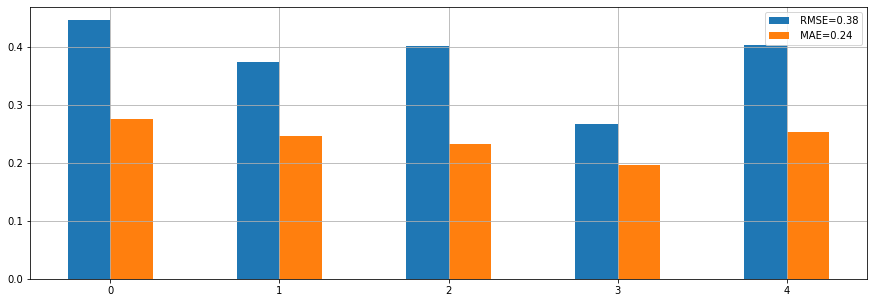

In [10]:
                             
scoring = {'mse':"neg_mean_squared_error", 'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}
GB = GBC.best_estimator_

######################################################

scoring = {'mse':"neg_mean_squared_error", 'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}

scor= cross_validate(GB, X, y, group, cv =cv,scoring=scoring)

mse1 = -scor['test_mse']
mae1 = -scor['test_mae']
r21=  -scor['test_r2']

labels = ['0','1', '2', '3', '4']
mse1 = np.sqrt(-scor['test_mse'])
mae1 = -scor['test_mae']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, mse1, width, label=" RMSE=%.2f"%(np.mean(mse1)),)
rects2 = ax.bar(x + width/2, mae1, width, label=" MAE=%.2f"%(np.mean(mae1)),)
plt.legend()
plt.grid()
print(np.mean(scor['test_r2']))

C:\Users\au327049\Conda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\au327049\Conda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


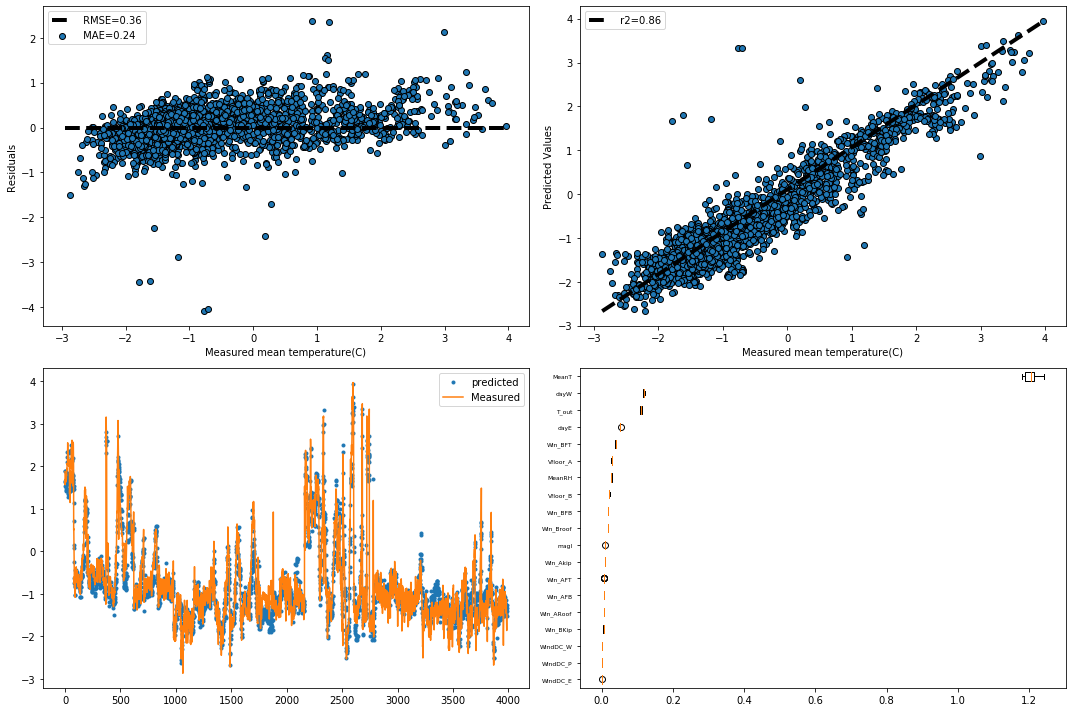

In [11]:
Y_pt=GB.predict(X_test)

mse1 = mse(Y_pt,y_test)
mae1 = mae(Y_pt,y_test)
r21=  r2(Y_pt,y_test)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(y_test,y_test-Y_pt, edgecolors=(0, 0, 0), label=" MAE=%.2f"%(mae1),)
plt.plot([y.min(),y.max()], [0,0], 'k--', lw=4, label=" RMSE=%.2f"%(np.sqrt(mse1)),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Residuals')
plt.legend()


plt.subplot(2,2,2)
plt.scatter(y_test,Y_pt, edgecolors=(0, 0, 0))
plt.plot([y_test.min(),y_test.max()], [Y_pt.min(),Y_pt.max()], 'k--', lw=4,label=" r2=%.2f"%(r21),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Predicted Values')
plt.legend()


ax=plt.subplot(2,2,3)
plt.plot(Y_pt,'.',label="predicted",)
plt.plot(y_test,label="Measured")
plt.legend()

import eli5
from eli5.sklearn import PermutationImportance
ax=plt.subplot(2,2,4)
feature_names = np.r_[Xnames]
result = permutation_importance(GB, X, y, n_repeats=20,
                               random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False)
ax.set_yticklabels(labels=feature_names[sorted_idx], minor=False,fontsize=6)
plt.tight_layout()
plt.show()  


In [12]:
import pickle
filename = 'GB_Model.sav'
pickle.dump(GB, open(filename, 'wb'))

In [13]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(GB, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = Xnames)

Weight,Feature
1.0478 ± 0.0296,MeanT
0.0880 ± 0.0077,T_out
0.0737 ± 0.0032,dayW
0.0445 ± 0.0044,Win_BFT
0.0400 ± 0.0029,dayE
0.0250 ± 0.0028,Vfloor_A
0.0230 ± 0.0040,Win_Broof
0.0201 ± 0.0027,MeanRH
0.0137 ± 0.0028,Vfloor_B
0.0116 ± 0.0031,Win_BFB
